In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgenmulti
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import gc
import os
import tensorflow as tf

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load the Dataset

In [6]:
SCRNA_DIR = '../data/scRNA/'
SCATAC_DIR = '../data/scATAC/'

## scRNA

In [7]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')
scrna

CPU times: user 556 ms, sys: 300 ms, total: 856 ms
Wall time: 2.4 s


AnnData object with n_obs × n_vars = 53638 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

## scATAC

In [8]:
%time scatac = sc.read_h5ad(SCATAC_DIR + 'peaks.h5ad')
scatac

CPU times: user 1.64 s, sys: 56.6 s, total: 58.2 s
Wall time: 1min 13s


AnnData object with n_obs × n_vars = 70461 × 20002 
    obs: 'FRIP', 'TotalReads', 'Group', 'Barcode', 'initialClusters', 'UMAP1', 'UMAP2', 'Clusters', 'cell_type', 'condition', 'nb_features', 'n_counts'
    var: 'score', 'scoreQuantile', 'name', 'GC', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_umap'

# Train the model

In [9]:
network = scgenmulti.VAEArithKeras2([scrna.shape[1], scatac.shape[1]],
                                     h_dimension=800, z_dimension=20,
                                     learning_rate=0.0001, alpha=0.01, beta=0.1)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 3000)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 20002)        0                                            
__________________________________________________________________________________________________
VAE_0 (Model)                   (None, 3000)         6143840     input_0[0][0]                    
__________________________________________________________________________________________________
VAE_1 (Model)                   (None, 20002)        33364042    input_1[0][0]                    
Total params: 39,507,882
Trainable params: 39,495,082
Non-trainable params: 12,800
_____________

In [10]:
batch_size = 30000
n_iter = 20
i, j, n = 0, 0, 0
history = []
for n in range(n_iter):
    print('-' * 50)
    print('Iteration: {}'.format(n))
    if i + batch_size < scrna.shape[0]:
        scrna_batch = scrna[i:i+batch_size]
    else:
        select = list(range(i, scrna.shape[0]))
        select += list(range(i + batch_size - scrna.shape[0]))
        scrna_batch = scrna[select]
    if j + batch_size < scatac.shape[0]:
        scatac_batch = scatac[j:j+batch_size]
    else:
        select = list(range(j, scatac.shape[0]))
        select += list(range(j + batch_size - scatac.shape[0]))
        scatac_batch = scatac[select]
        
    i = (i + batch_size) % scrna.shape[0]
    j = (j + batch_size) % scatac.shape[0]
    
    %time history.append(network.train([scrna_batch, scatac_batch], n_epochs=1, batch_size=128, verbose=1))
    
    del scrna_batch
    del scatac_batch
    gc.collect()

--------------------------------------------------
Iteration: 0

Epoch 1/1
30000/30000 [==============================] - 17s 574us/step - loss: 1011.1483 - VAE_0_loss: 212.5537 - VAE_1_loss: 798.4214 - VAE_0_kl_loss: 232.1522 - VAE_0_recon_loss: 210.2723 - VAE_0_kl_loss_latents: 0.9188 - VAE_1_kl_loss: 232.1522 - VAE_1_recon_loss: 796.0493 - VAE_1_kl_loss_latents: 0.9188
CPU times: user 33.1 s, sys: 15.1 s, total: 48.1 s
Wall time: 53.9 s
--------------------------------------------------
Iteration: 1
Epoch 1/1
30000/30000 [==============================] - 14s 464us/step - loss: 865.2216 - VAE_0_loss: 174.8598 - VAE_1_loss: 690.3918 - VAE_0_kl_loss: 293.2457 - VAE_0_recon_loss: 171.9071 - VAE_0_kl_loss_latents: 0.5720 - VAE_1_kl_loss: 293.2457 - VAE_1_recon_loss: 687.3354 - VAE_1_kl_loss_latents: 0.5720
CPU times: user 20.7 s, sys: 10.4 s, total: 31.1 s
Wall time: 26.9 s
--------------------------------------------------
Iteration: 2
Epoch 1/1
30000/30000 [===========================

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


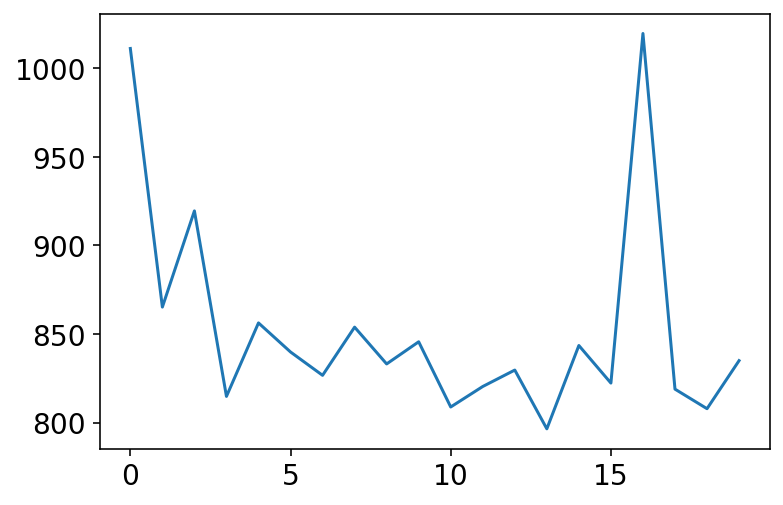

In [11]:
plt.plot([i.history['loss'] for i in history]);

# Visualization

## Latent space of scRNA-seq

In [12]:
scrna_latent = network.to_latent(scrna.X, 0)[0]
scrna_latent = sc.AnnData(scrna_latent)
scrna_latent.obs = scrna.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

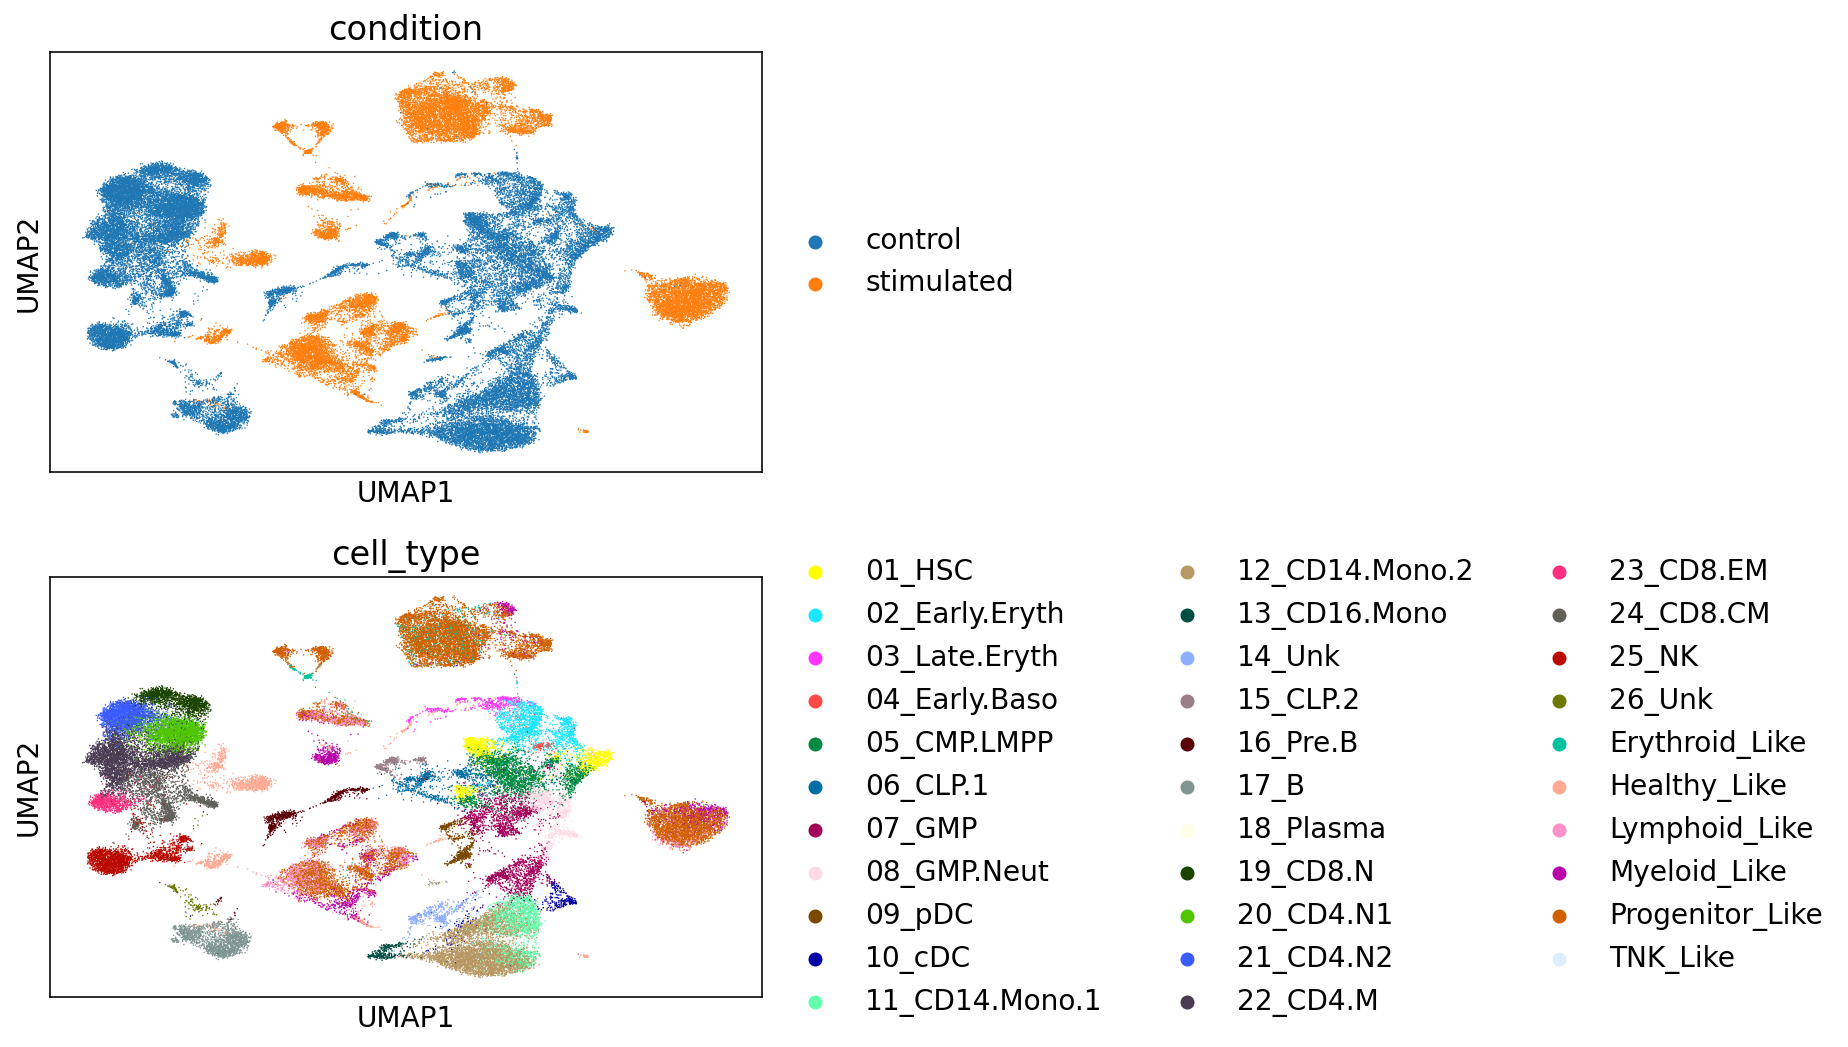

In [13]:
sc.pp.neighbors(scrna_latent, random_state=42)
sc.tl.umap(scrna_latent, random_state=42)
sc.pl.umap(scrna_latent, color=['condition', 'cell_type'], ncols=1)

## Latent space of scATAC-seq

In [14]:
scatac_latent = network.to_latent(scatac.X, 1)[0]
scatac_latent = sc.AnnData(scatac_latent)
scatac_latent.obs = scatac.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


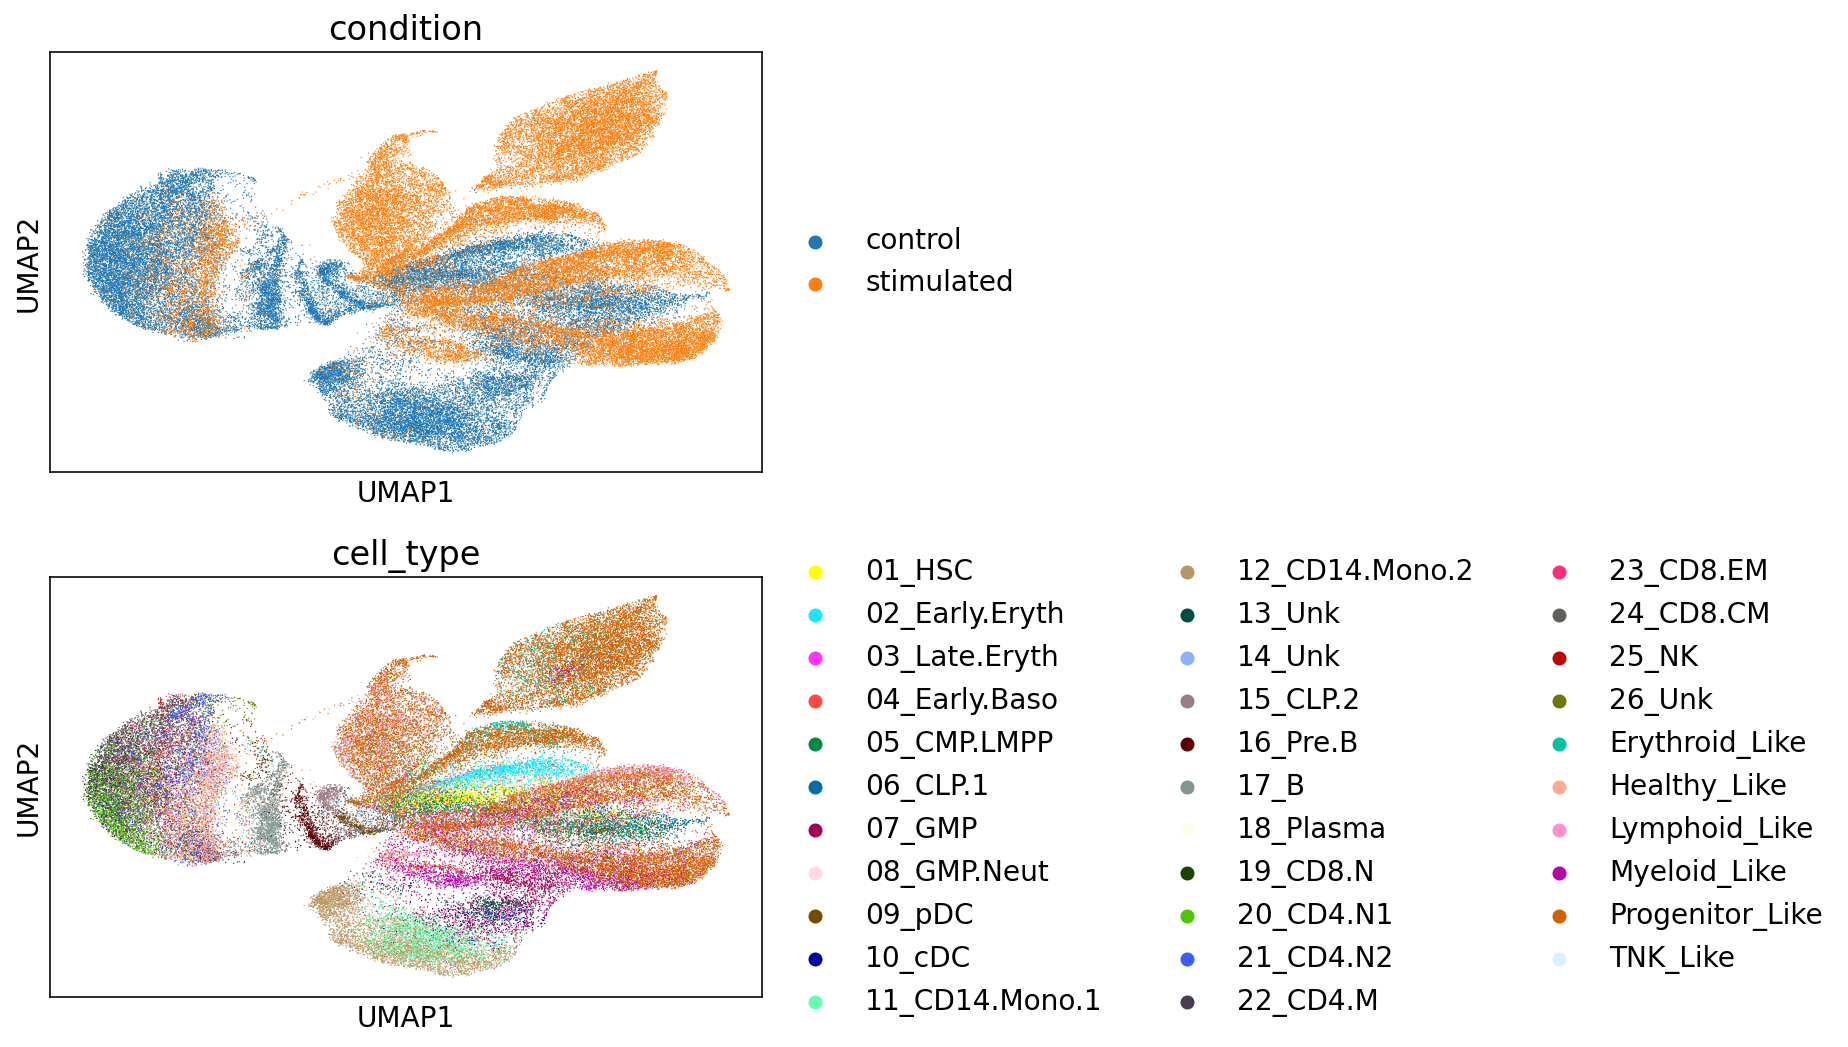

CPU times: user 3min 26s, sys: 4.42 s, total: 3min 30s
Wall time: 1min 49s


In [15]:
%%time
sc.pp.neighbors(scatac_latent, random_state=42)
sc.tl.umap(scatac_latent, random_state=42)
sc.pl.umap(scatac_latent, color=['condition', 'cell_type'], ncols=1)

In [16]:
scall_latent = np.concatenate([scrna_latent.X, scatac_latent.X], axis=0)

scall_latent = sc.AnnData(scall_latent)
scrnaobs = scrna.obs
scatacobs = scatac.obs
scrnaobs['modality'] = 'scRNA-seq'
scatacobs['modality'] = 'scATAC-seq'

scall_latent.obs = pd.concat([scrnaobs, scatacobs])

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'modality' as categorical
... storing 'initialClusters' as categorical
... storing 'Clusters' as categorical


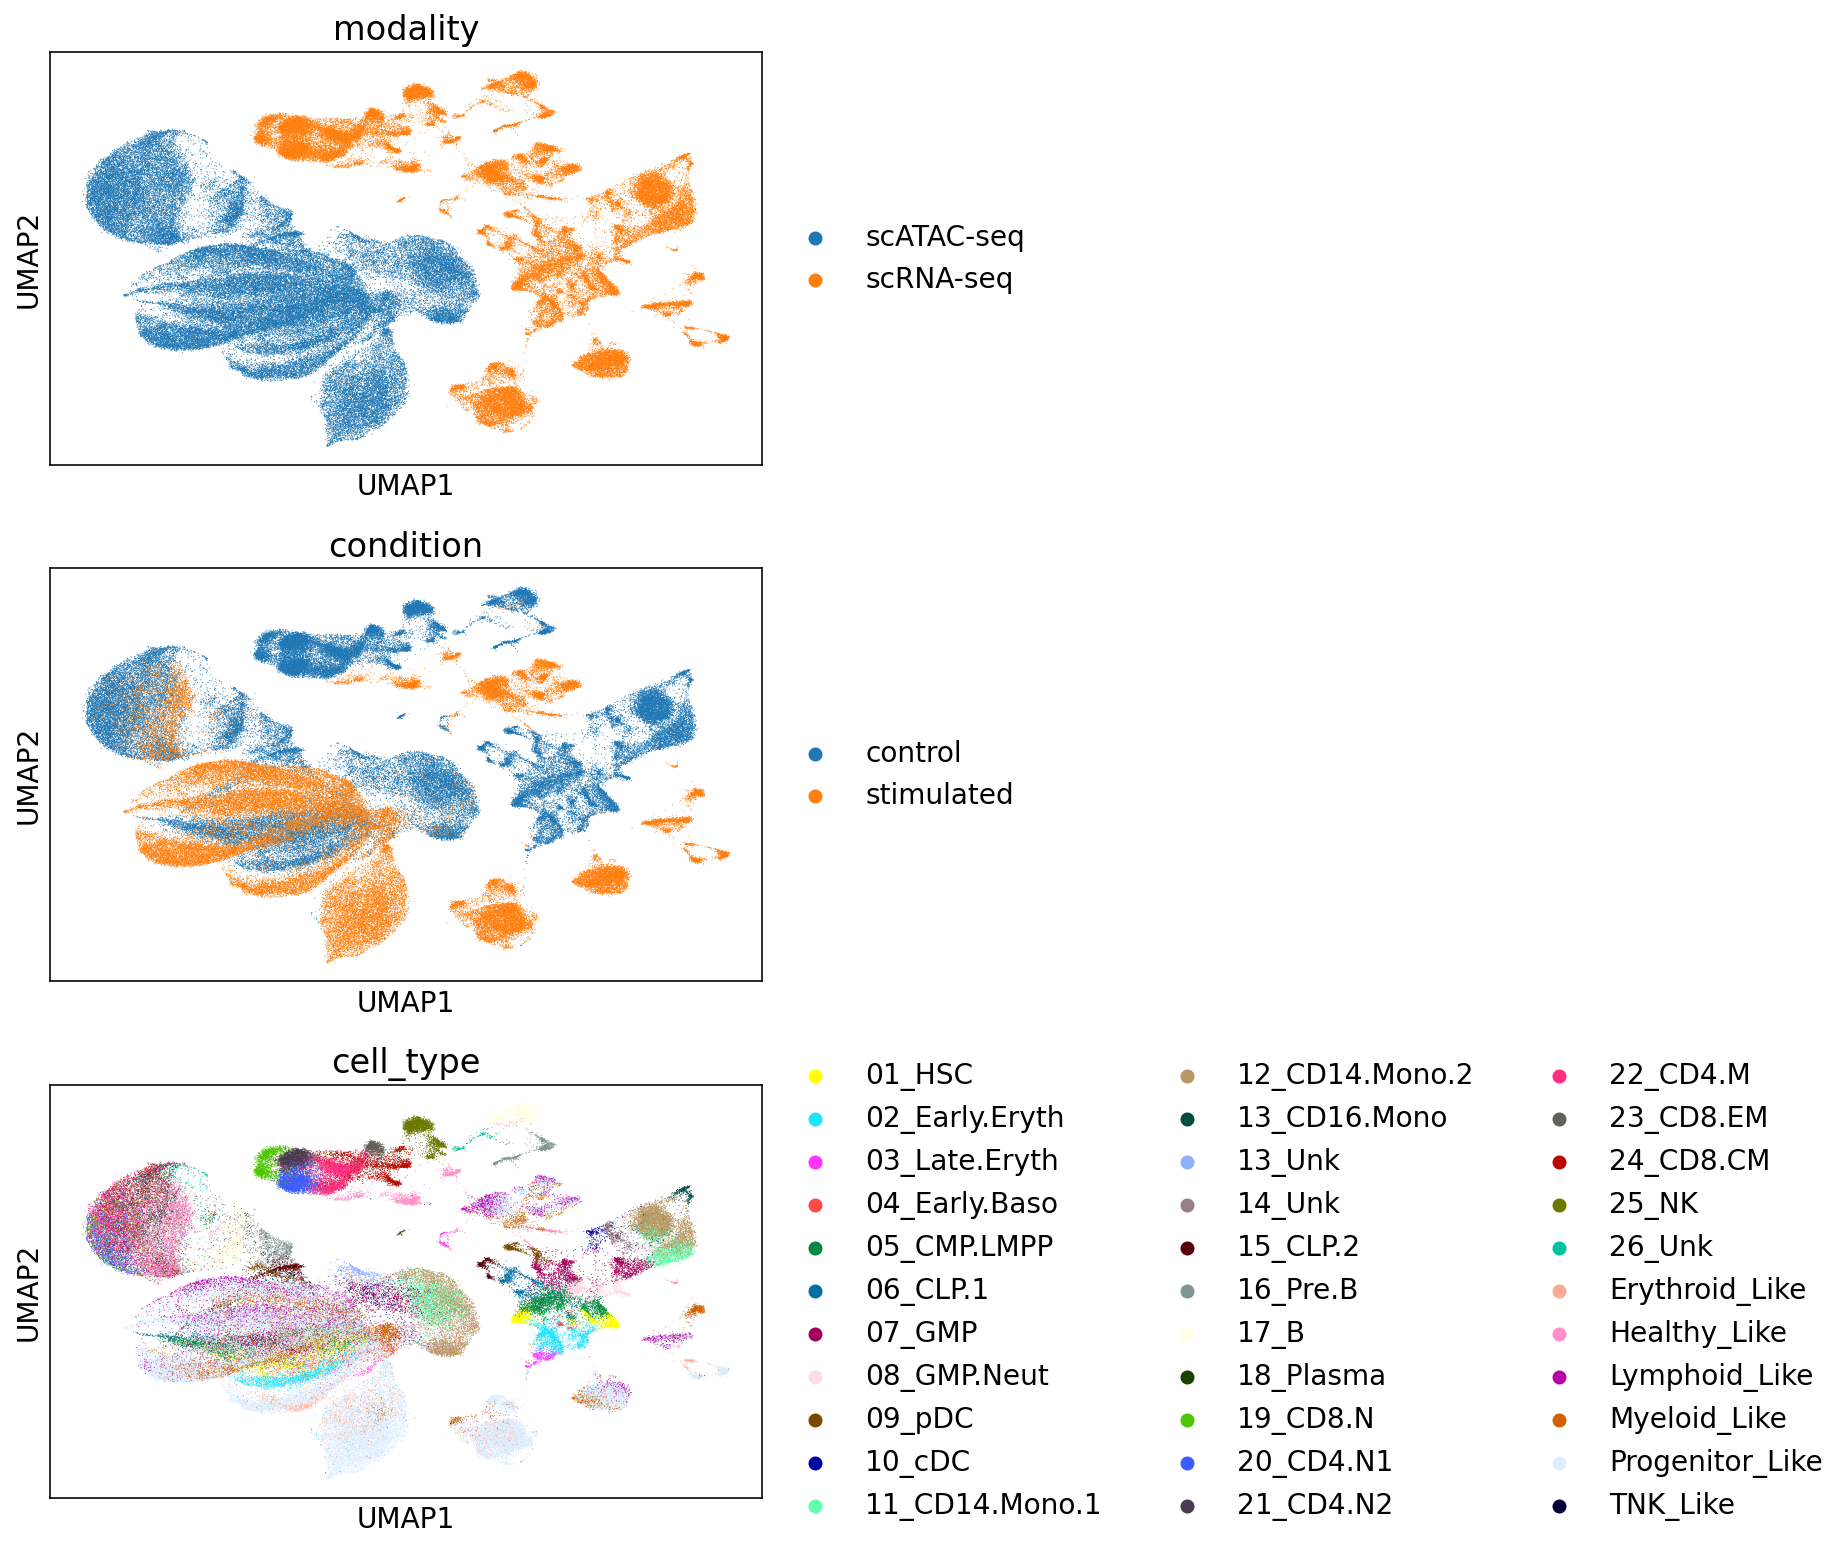

CPU times: user 16min 21s, sys: 28.6 s, total: 16min 49s
Wall time: 6min 14s


In [17]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)

# Integrate

In [19]:
scrna_mean = np.mean(scrna_latent.X, axis=0, keepdims=True)
scatac_mean = np.mean(scatac_latent.X, axis=0, keepdims=True)

for ct in scall_latent.obs['cell_type'].unique():
    scrna_ct = scall_latent[(scall_latent.obs['modality'] == 'scRNA-seq') & (scall_latent.obs['cell_type'] == ct)]
    scatac_ct = scall_latent[(scall_latent.obs['modality'] == 'scATAC-seq') & (scall_latent.obs['cell_type'] == ct)]
    if scrna_ct.shape[0] == 0:
        scrna_ct_mean = scrna_mean
    else:
        scrna_ct_mean = np.mean(scrna_ct.X, axis=0, keepdims=True)
    if scatac_ct.shape[0] == 0:
        scatac_ct_mean = scatac_mean
    else:
        scatac_ct_mean = np.mean(scatac_ct.X, axis=0, keepdims=True)
        
    delta = scatac_ct_mean - scrna_ct_mean
    scrna_ct.X += delta

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


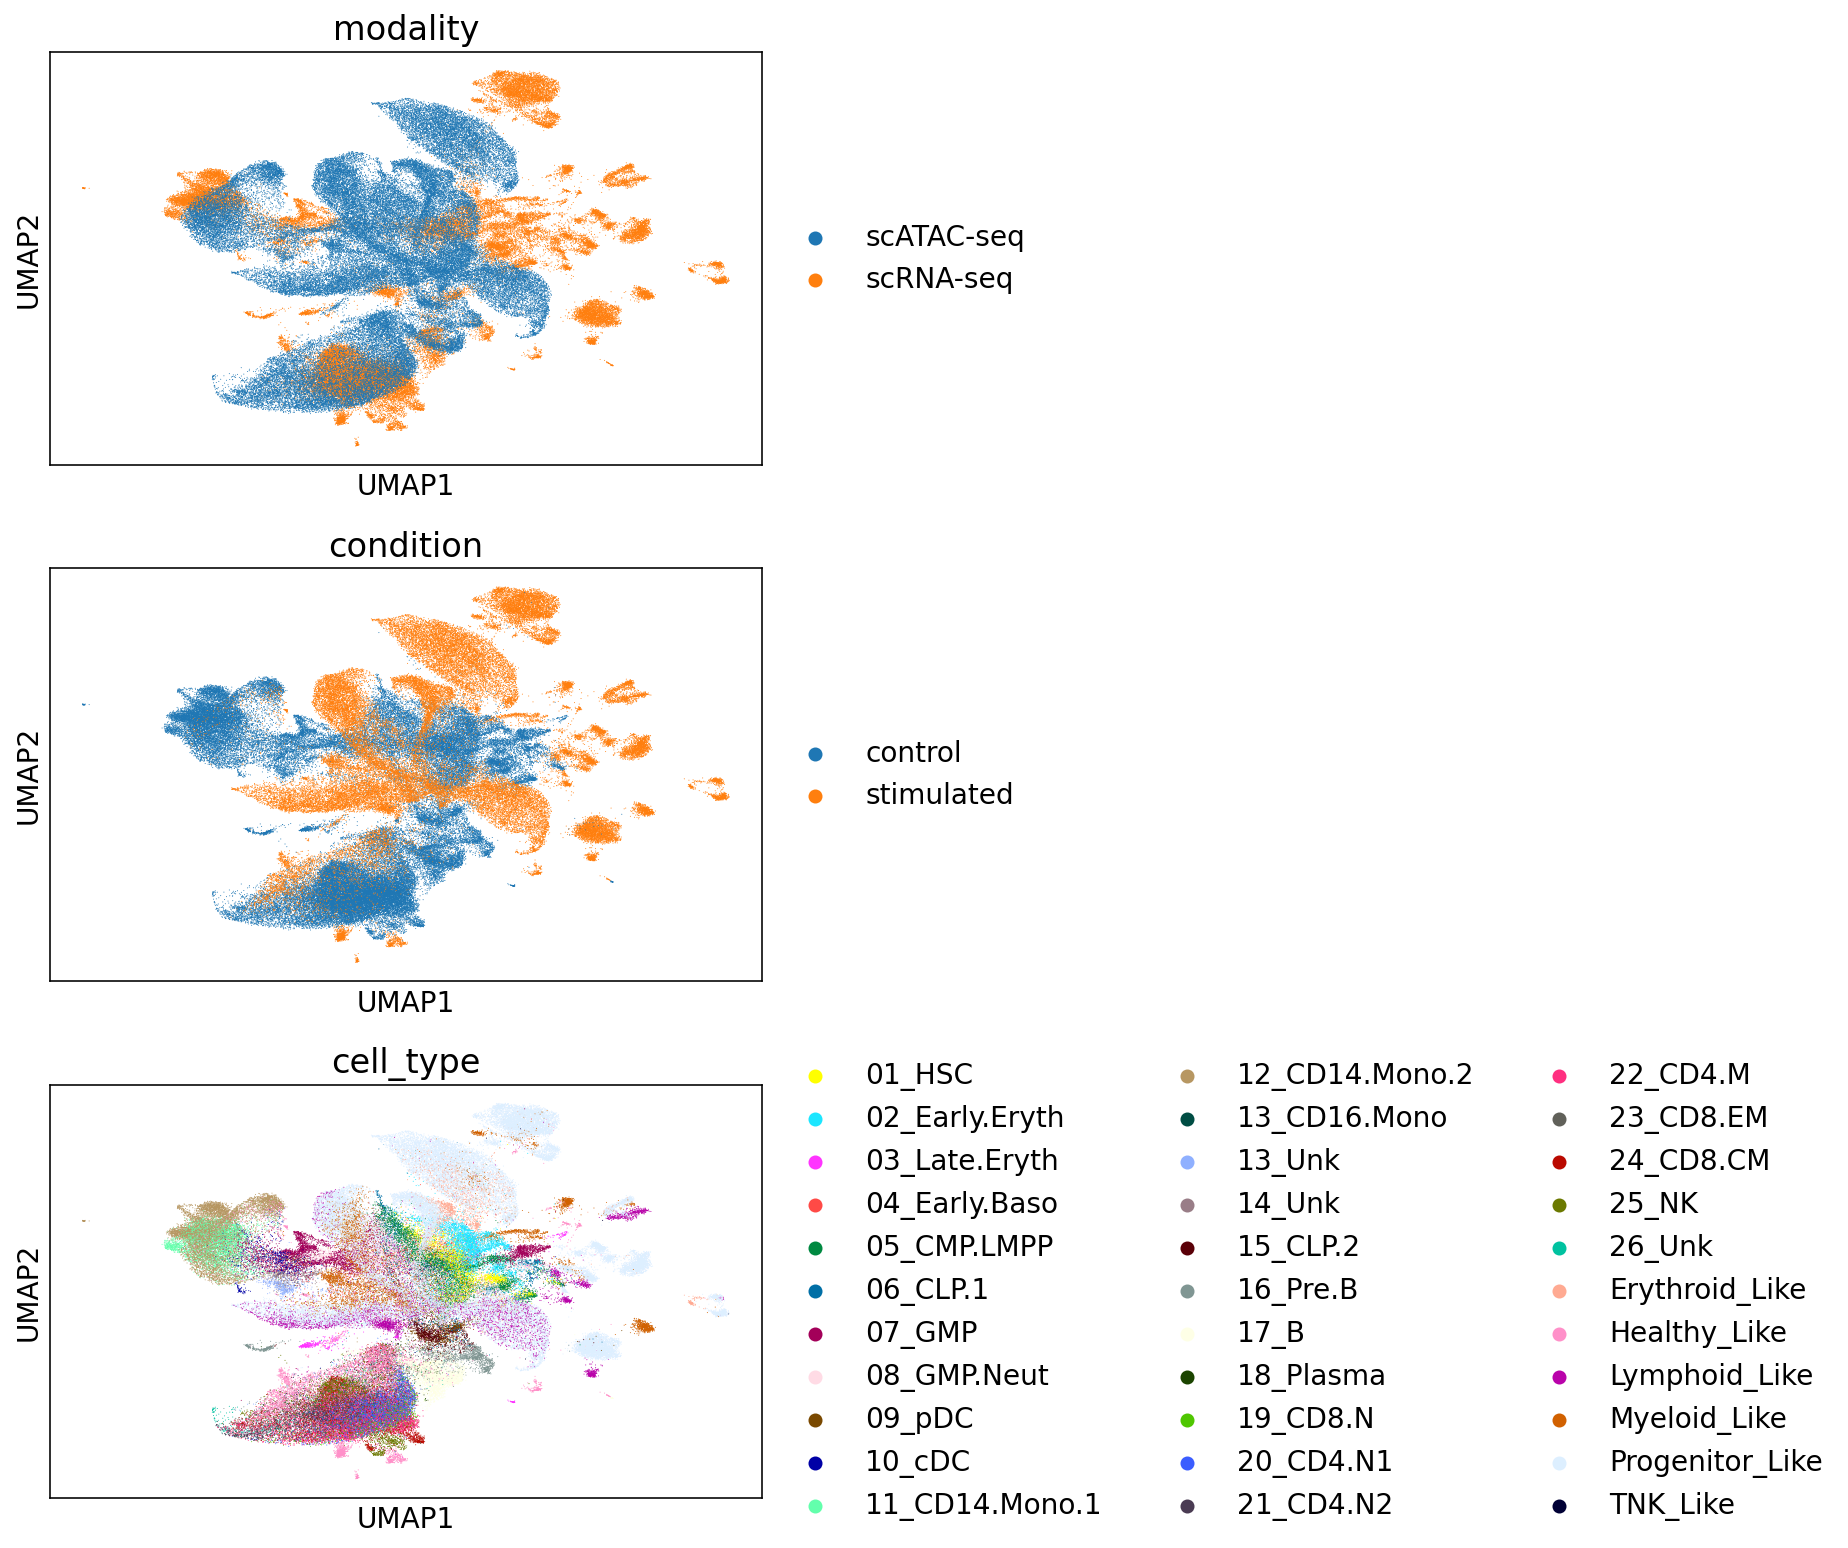

CPU times: user 11min 19s, sys: 19.2 s, total: 11min 38s
Wall time: 5min 36s


In [20]:
%%time
sc.pp.neighbors(scall_latent, random_state=42)
sc.tl.umap(scall_latent, random_state=42)
sc.pl.umap(scall_latent, color=['modality', 'condition', 'cell_type'], ncols=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


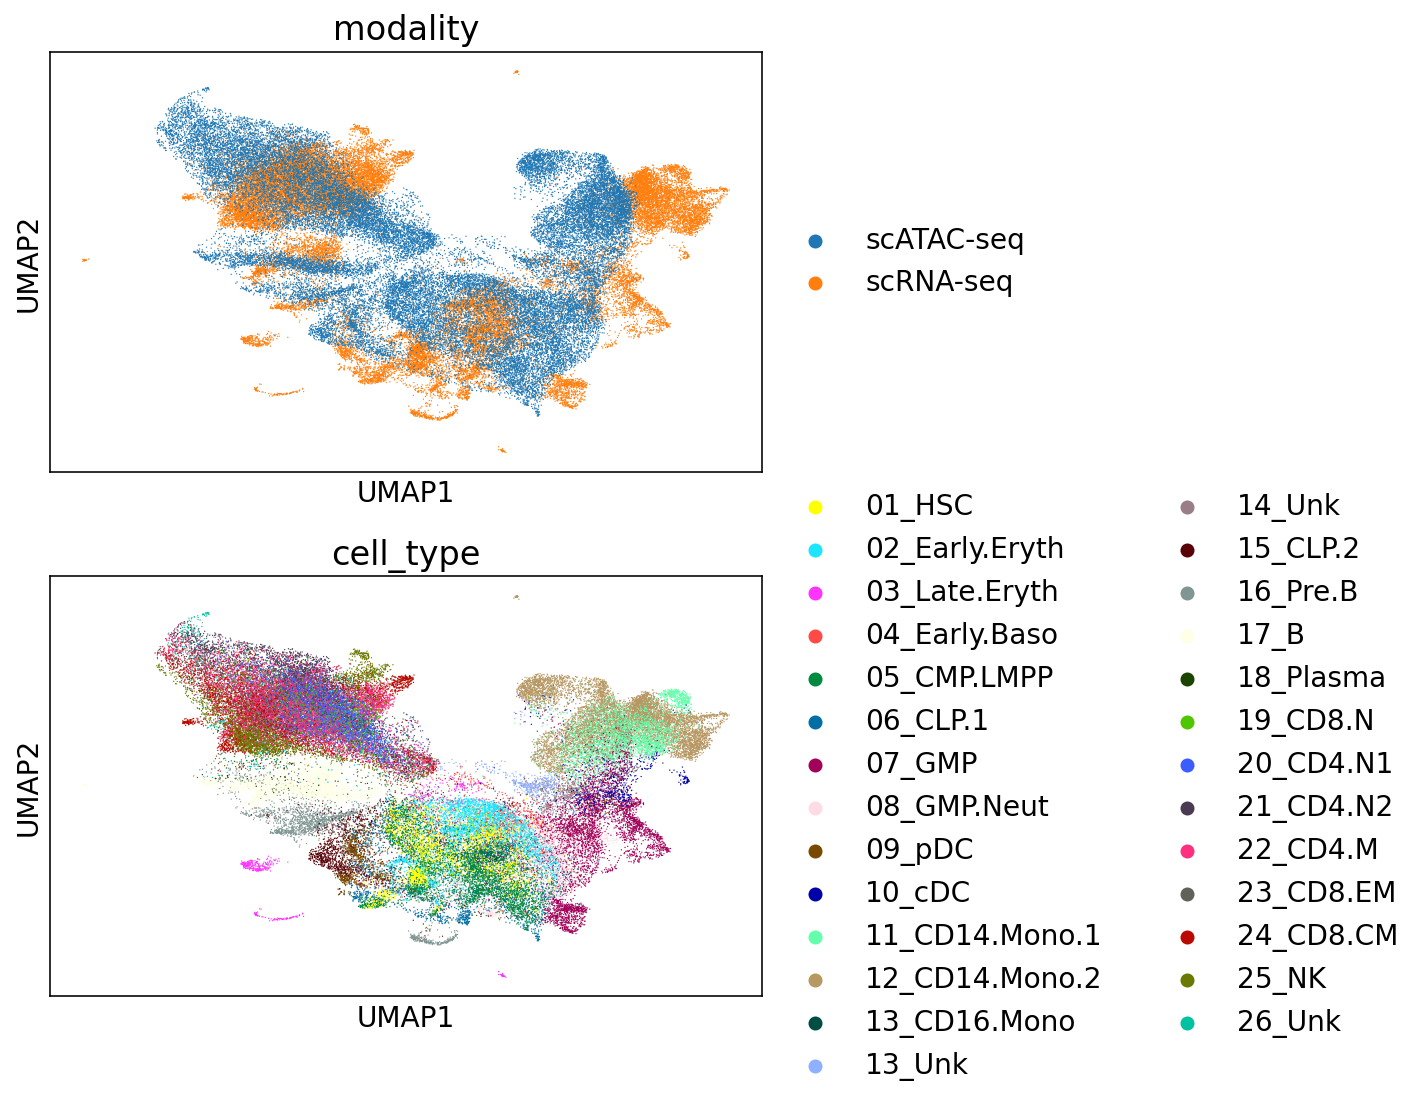

CPU times: user 5min 1s, sys: 6.29 s, total: 5min 7s
Wall time: 3min 3s


In [21]:
%%time
scall_latent_ctrl = scall_latent[scall_latent.obs['condition'] == 'control']
sc.pp.neighbors(scall_latent_ctrl, random_state=42)
sc.tl.umap(scall_latent_ctrl, random_state=42)
sc.pl.umap(scall_latent_ctrl, color=['modality', 'cell_type'], ncols=1)

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


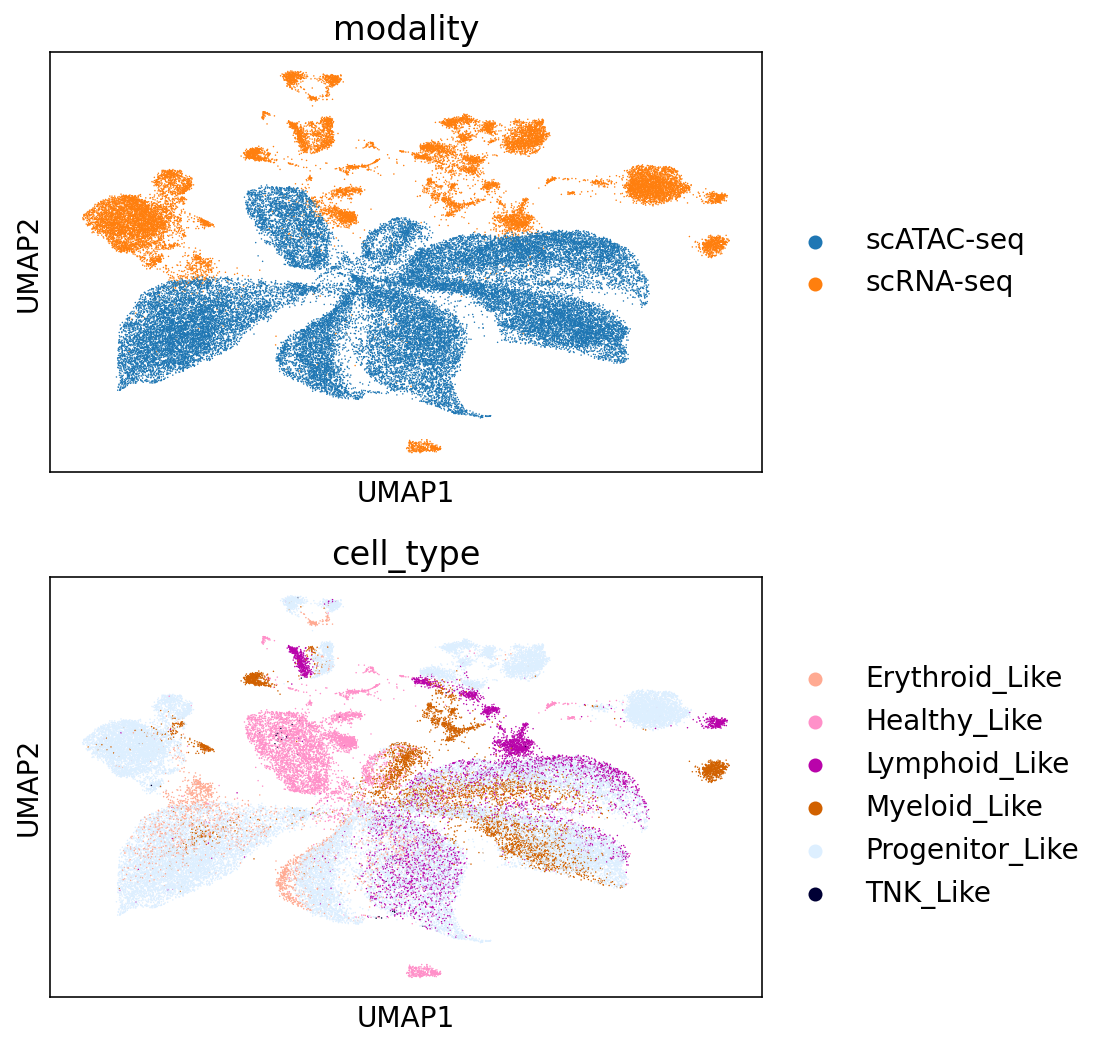

CPU times: user 3min 50s, sys: 6.33 s, total: 3min 56s
Wall time: 2min 5s


In [22]:
%%time
scall_latent_stim = scall_latent[scall_latent.obs['condition'] == 'stimulated']
sc.pp.neighbors(scall_latent_stim, random_state=42)
sc.tl.umap(scall_latent_stim, random_state=42)
sc.pl.umap(scall_latent_stim, color=['modality', 'cell_type'], ncols=1)